In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# Preparacao dos dados

In [ ]:
!gdown https://drive.google.com/uc?id=1fyfRuFWmDYi_HSN0reL_YcA1Kj7vw1NS

Downloading...
From: https://drive.google.com/uc?id=1fyfRuFWmDYi_HSN0reL_YcA1Kj7vw1NS
To: /content/one piece.zip
100% 803M/803M [00:05<00:00, 139MB/s] 


In [ ]:
!unzip "one piece.zip"

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: Data/Franky/205.png     
  inflating: Data/Franky/205_inverted.png  
  inflating: Data/Franky/206.png     
  inflating: Data/Franky/206_inverted.png  
  inflating: Data/Franky/207.png     
  inflating: Data/Franky/207_inverted.png  
  inflating: Data/Franky/208.png     
  inflating: Data/Franky/208_inverted.png  
  inflating: Data/Franky/209.png     
  inflating: Data/Franky/209_inverted.png  
  inflating: Data/Franky/20_inverted.png  
  inflating: Data/Franky/21.png      
  inflating: Data/Franky/210.png     
  inflating: Data/Franky/210_inverted.png  
  inflating: Data/Franky/211.png     
  inflating: Data/Franky/211_inverted.png  
  inflating: Data/Franky/212.png     
  inflating: Data/Franky/212_inverted.png  
  inflating: Data/Franky/213.png     
  inflating: Data/Franky/213_inverted.png  
  inflating: Data/Franky/214.png     
  inflating: Data/Franky/214_inverted.png  
  inflating: Data/Franky/216.png

# Pre processing

In [ ]:
def preprocess (random_seed = 1):
    path = '/content/Data'
    labels=[]    
    filepaths=[]
    classlist = os.listdir(path)

    for classe in classlist:
        classpath=os.path.join(path, classe)
        file_list = os.listdir(classpath)

        for file in file_list:
            filepaths.append(os.path.join(classpath, file))
            labels.append(classe)

    files_pd = pd.Series(filepaths, name='filepaths')
    labels_pd = pd.Series(labels, name='labels')
    df = pd.concat([files_pd, labels_pd], axis=1) 
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=random_seed, stratify=df['labels'])

    return train_df, test_df

In [ ]:
train_df, test_df = preprocess()
# !ls /content/Data -a

In [ ]:
train_df.head(5)

,filepaths,labels
6270,/content/Data/Brook/204.png,Brook
1999,/content/Data/Nami/rotated_119.jpg,Nami
4434,/content/Data/Sanji/RotatedL2.jpg,Sanji
1822,/content/Data/Zoro/Edited111.jpg.jpg,Zoro
2288,/content/Data/Nami/32_inverted.png,Nami


In [ ]:
test_df.head(5)

,filepaths,labels
1779,/content/Data/Zoro/38.jpg,Zoro
169,/content/Data/Jinbei/10.png_inverted.png,Jinbei
1828,/content/Data/Zoro/[0.54815896]inverted.jpg,Zoro
3075,/content/Data/Luffy/Edited37.jpg.jpg,Luffy
1328,/content/Data/Zoro/Edited117.jpg.jpg,Zoro


In [ ]:
img_size = (224,224)

def scalar(img):    
    return img

train_generator = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
test_generator = ImageDataGenerator(preprocessing_function=scalar)

train_gen = train_generator.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=32)

test_gen= test_generator.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=32)

Found 4574 validated image filenames belonging to 10 classes.
Found 1961 validated image filenames belonging to 10 classes.


# Modelo

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max') 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        

output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
history = model.fit(x=train_gen,  epochs=15, verbose=1, initial_epoch=0)

Epoch 1/15
  4/143 [..............................] - ETA: 2:29 - loss: 11.0520 - accuracy: 0.0938

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


143/143 [==============================] - 186s 1s/step - loss: 7.8694 - accuracy: 0.6810
Epoch 2/15
143/143 [==============================] - 156s 1s/step - loss: 5.2558 - accuracy: 0.9388
Epoch 3/15
143/143 [==============================] - 156s 1s/step - loss: 3.7234 - accuracy: 0.9812
Epoch 4/15
143/143 [==============================] - 155s 1s/step - loss: 2.6357 - accuracy: 0.9899
Epoch 5/15
143/143 [==============================] - 155s 1s/step - loss: 1.8476 - accuracy: 0.9913
Epoch 6/15
143/143 [==============================] - 156s 1s/step - loss: 1.2882 - accuracy: 0.9928
Epoch 7/15
143/143 [==============================] - 155s 1s/step - loss: 0.8979 - accuracy: 0.9969
Epoch 8/15
143/143 [==============================] - 155s 1s/step - loss: 0.6478 - accuracy: 0.9961
Epoch 9/15
143/143 [==============================] - 156s 1s/step - loss: 0.4851 - accuracy: 0.9976
Epoch 10/15
143/143 [==============================] - 155s 1s/step - loss: 0.3928 - accuracy: 0.9980


# Avaliacao

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f'loss on test set = {loss}')
print(f'accuracy on test set = {accuracy}')

 1/62 [..............................] - ETA: 2:58 - loss: 0.2633 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


62/62 [==============================] - 20s 274ms/step - loss: 0.2119 - accuracy: 0.9924
loss on test set = 0.2118585854768753
accuracy on test set = 0.9923508167266846


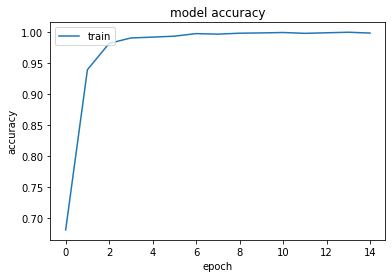

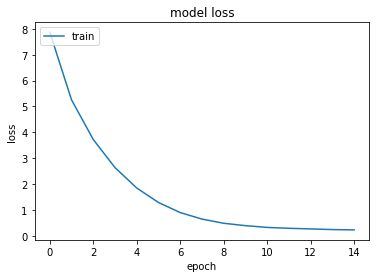

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from keras.models import load_model

In [ ]:
!gdown https://drive.google.com/uc?id=1aydMMdyJ-C_Mmgk-bWAHurwhBDJ8rXMN

Downloading...
From: https://drive.google.com/uc?id=1aydMMdyJ-C_Mmgk-bWAHurwhBDJ8rXMN
To: /content/my_model.h5
100% 135M/135M [00:01<00:00, 74.1MB/s]


In [ ]:
model = load_model('my_model.h5')

(398, 182, 3)


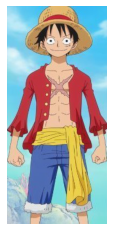

In [ ]:
img_path=r'Data/Luffy/1.jpg'
img=plt.imread(img_path)
print (img.shape)
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224, 3))

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)

(1, 224, 224, 3)


In [ ]:
from enum import Enum

In [ ]:
class ClassNames(Enum):
  BROOK = 0
  CHOPPER = 1
  FRANKY = 2
  JINBEI = 3
  LUFFY = 4
  NAMI = 5
  ROBIN = 6
  SANJI = 7
  USOPP = 8
  ZORO = 9

In [ ]:
classes = np.argmax(preds, axis = 1)
print('Success' if classes[0] == ClassNames.LUFFY.value else 'Failed')

Success
